# ImageNet

To train a diffusion model to generate images conditioned on activations, we need to extract those activations from some model that is looking at some dataset.
I have a trained GoogLeNet look at ImageNet images, but due to compute constraints, I could not have GoogLeNet look at all ImageNet images, but only at the first 17760 (which is about 1% of the entire dataset).
Here I look at whether that is a problem.

In [ ]:
#| echo: false
%cd ..

In [30]:
#| echo: false
from sparse_autoencoder.data import ImageNet
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

In [ ]:
#| code-fold: true
NUM_DATA = 17760
BATCH_SIZE = 64

ds = DataLoader(
    ImageNet('res/imagenet/train'),
    shuffle=False,
    batch_size=BATCH_SIZE
)
len(ds)

In [69]:
NUM_BATCHES = NUM_DATA // BATCH_SIZE
label_count = np.zeros(1000)
for i, (images, labels) in zip(range(NUM_BATCHES), ds):
    for label in labels:
        label_count[label] += 1
    if i % (NUM_BATCHES // 10) == 0:
        print(f".", end='', flush=True)
print()

expected_mean = NUM_DATA / 1000
label_count.min(), label_count.max(), label_count.mean(), expected_mean

...........


(5.0, 33.0, 17.728, 17.76)

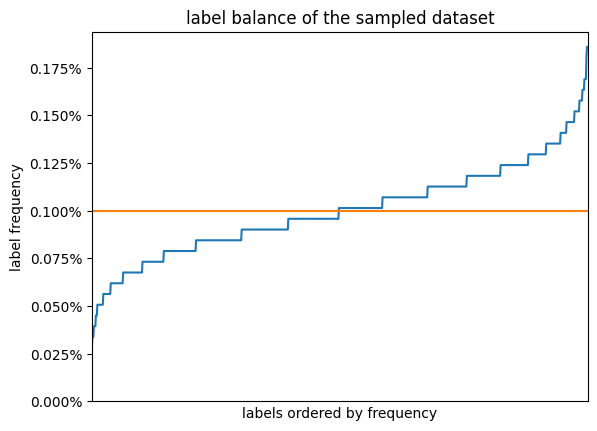

In [32]:
#| label: fig-label-balance
#| code-fold: true
fig, ax = plt.subplots()
ax.plot(np.arange(1000), sorted(100 * label_count / NUM_DATA))
ax.plot([0, 999], [0.1, 0.1])
ax.set_ylim(bottom=0)
ax.set_xlim(left=0, right=1000)
ax.set_title("label balance of the sampled dataset")
ax.set_xticks([])
ax.set_xlabel("labels ordered by frequency")
ax.set_ylabel("label frequency")
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.show()

The sample of the dataset seems reasonably balanced. But a few labels are over- or underrepresented and only by a magnitude of 2 from the mean.

## Image Compression

Let's see how much smaller we can make the images without losing recognisabillity.

In [71]:
sample_images, sample_labels = next(iter(ds))
tuple(sample_images.shape), sample_labels.shape[0]

((64, 3, 224, 224), 64)

Not all images are of the same original size, or have all 3 colors.
I used the same preprocessing steps as the [pytorch implementation](https://github.com/Lornatang/GoogLeNet-PyTorch) to have all images be in the same shape before passing them on to GoogLeNet.

We need to undo some of those steps, in order for matplotlib to present the image well.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


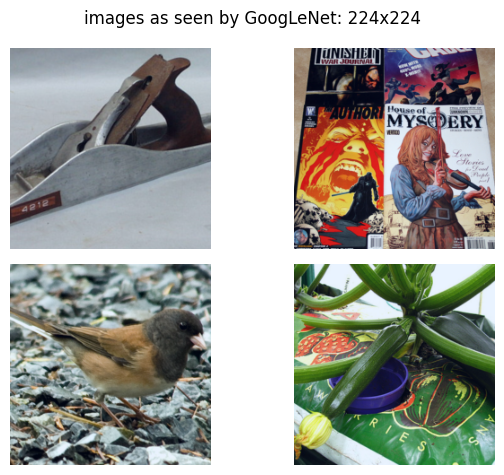

In [61]:
from torchvision.transforms import Resize

def prepare_image(img, new_size=224, min_=-2.1008, max_=2.6400):
    img = Resize([new_size, new_size], antialias=True)(img)
    # channels, height, width  ->  height, width, channels
    img = img.permute(1, 2, 0)
    # have the image's values range between 0 and 1
    img = (img - min_) / (max_ - min_)
    return img

fig, axes = plt.subplots(2,2)
for i, ax in enumerate(axes.flat):
    image = prepare_image(sample_images[i])
    ax.axis('off')
    ax.imshow(image)

plt.suptitle("images as seen by GoogLeNet: 224x224")
plt.tight_layout()
plt.show()

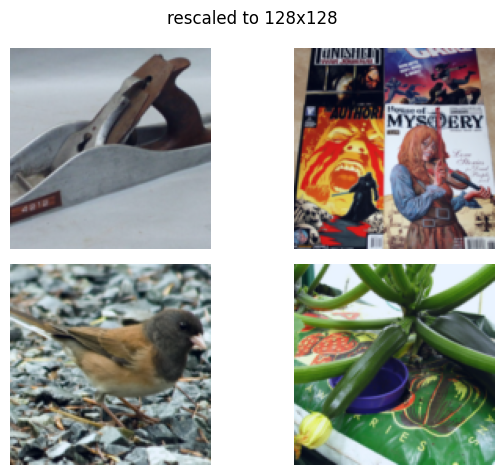

In [66]:
#| code-fold: true
fig, axes = plt.subplots(2,2)
for i, ax in enumerate(axes.flat):
    image = prepare_image(sample_images[i], 128)
    ax.axis('off')
    ax.imshow(image)

plt.suptitle("rescaled to 128x128")
plt.tight_layout()
plt.show()

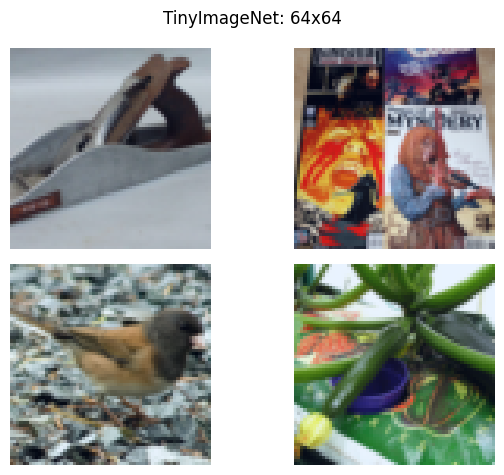

In [67]:
#| code-fold: true
fig, axes = plt.subplots(2,2)
for i, ax in enumerate(axes.flat):
    image = prepare_image(sample_images[i], 64)
    ax.axis('off')
    ax.imshow(image)

plt.suptitle("TinyImageNet: 64x64")
plt.tight_layout()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


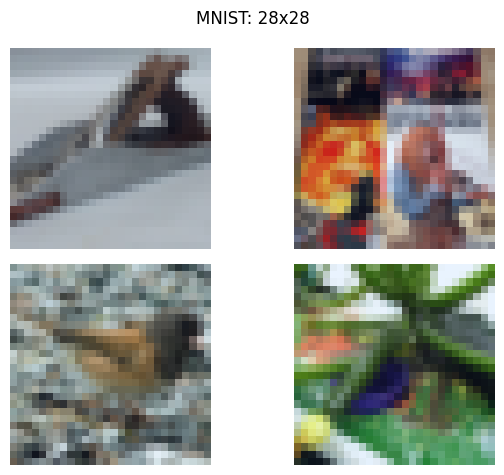

In [68]:
#| code-fold: true
fig, axes = plt.subplots(2,2)
for i, ax in enumerate(axes.flat):
    image = prepare_image(sample_images[i], 28)
    ax.axis('off')
    ax.imshow(image)

plt.suptitle("MNIST: 28x28")
plt.tight_layout()
plt.show()

The 64x64 image seems to still be recognisable enough for a human. For testing purposes I will go with the 28x28 and probably go for 64x64 when training the Conditional Diffusion Model.